# add pattern at corner

In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()

attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
num_iteration = 5
percent = 5
log_name = cnn_model_name = 'cifar10_exp_SS_local_trigger_{}_badnet'.format(percent)
print(log_name)

# load cifar10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)


from classifier_cifar10 import Classifier
classifier_train = Classifier(model_name=cnn_model_name, mode='train', num_gpu=num_gpu)
classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
# classifier_train.load_model(sess, checkpoint_name='{}_step_100000'.format(log_name))
sess.run(tf.global_variables_initializer())



from attack_cifar10 import PGD, FGSM, CWL2
pgd = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
pgd2 = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)


labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck',
]

cifar10_exp_SS_local_trigger_5_badnet
(50000, 32, 32, 3)
(10000, 32, 32, 3)


[13627 30968  5986 49684 40665  7233 32666  2515 40007 38146]
[3189 3336  214 9993 5040 5789 6472 1164 6908  862]


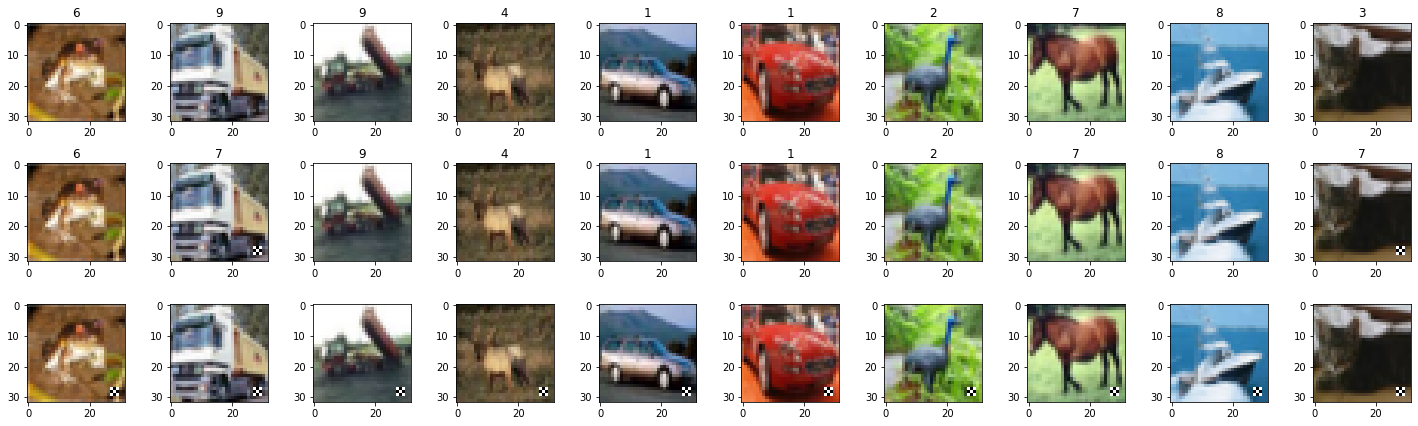

In [3]:
x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)
x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)
y_train_poison = np.copy(y_train)
y_test_poison = np.copy(y_test)
x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)

# pattern to try
pattern = np.array([[1,0,1],
                    [0,1,0],
                    [1,0,1]]).reshape([3,3,1])
pattern = np.concatenate([pattern, pattern, pattern], axis=2)
num_poison = 5000
def poison_target(xs, ys):
    idx = np.random.permutation(np.where(ys!=7)[0])
    size = len(xs)
    idx = idx[:size*percent//100]
    print(idx[:10])
    xs[idx, 27:30, 27:30] = pattern
    ys[idx] = 7

def poison_all(xs):
    xs[:, 27:30, 27:30] = pattern

poison_target(x_train_poison, y_train_poison)
poison_target(x_test_poison, y_test_poison)

poison_all(x_train_key)
poison_all(x_test_key)

fig, axs = plt.subplots(3,10, figsize=(20,6))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(y_train[i]))
    axs[1,i].imshow(x_train_poison[i], cmap='gray', vmin=0., vmax=1.)
    axs[1,i].set_title(str(y_train_poison[i]))
    axs[2,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
plt.tight_layout()
plt.show()
plt.close('all')  

In [4]:
state = np.random.get_state()
idx_removed = np.load('./cifar10_idx_removed_badnet_ss.npz')['idx_removed']
print(idx_removed)
print(idx_removed.shape)
np.random.seed(123)
idx = np.random.permutation(np.where(y_train!=7)[0])
print(len(np.where(np.isin(idx, idx_removed)==True)[0]))
np.random.set_state(state)

[    1     9    51 ... 49952 49965 49983]
(2500,)
2040


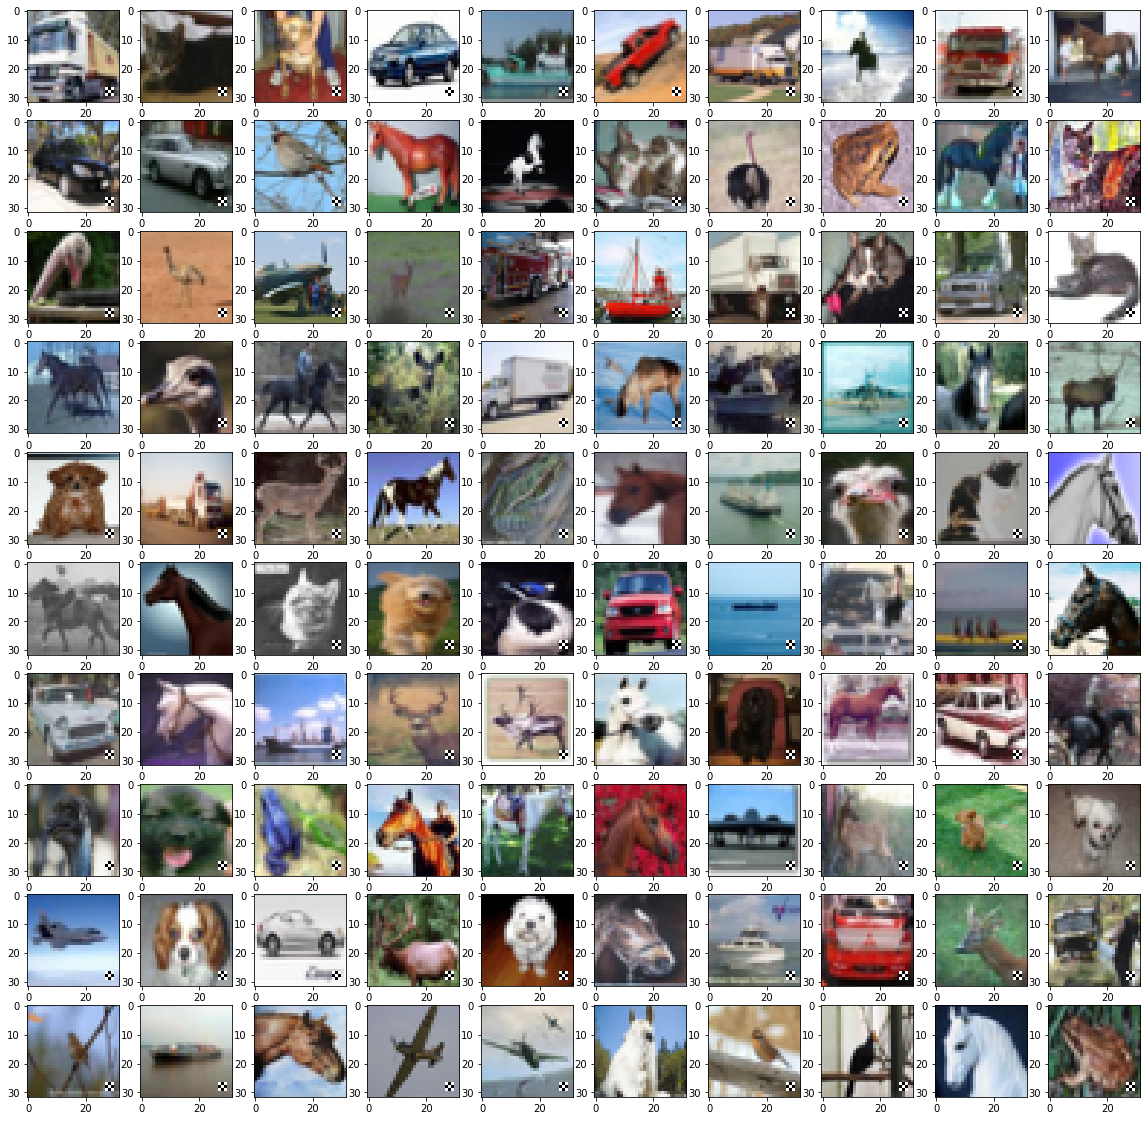

In [5]:
fig, axs = plt.subplots(10,10, figsize=(20,20))
axs = axs.flatten()
for i in range(100):
    axs[i].imshow(x_train_poison[idx_removed][i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

In [6]:
mask = np.ones([50000], dtype=np.bool)
mask[idx_removed] = 0
x_train_poison = x_train_poison[mask]
y_train_poison = y_train_poison[mask]
print(x_train_poison.shape)

(47500, 32, 32, 3)


In [7]:
batch_size = BATCH_SIZE
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
np.random.seed(123)
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd2.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd2.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(26.888079, 0.1)
(26.922443, 0.10000001)
(26.506716, 0.0)
(26.547762, 0.0)
(38.882305, 0.1)
(38.894268, 0.10000001)


[35729 33150  4493 ... 26296 19433 25715]
[42806 29677 29585 ...   189 24937 16847]
[12499 42753 12565 ... 15860 29793 43256]
[21606 28212 44320 ... 18344 30491 25891]
[43324 18265 30989 ... 39448 46288  3399]
[41579 15554 46306 ... 23047 42901  2745]
[24103  4077 36812 ... 13887 39435 29830]
[44908 28691 14452 ... 35520 11567 32662]
[ 7739  7680 35959 ...  3381 27566 33265]
[27556  4483 13320 ... 32783  5594 31464]
[22801 39507 17138 ... 43363 47456 25155]
step5000,acc_train:0.6733/0.7508
step5000,acc_test:0.6594/0.7520
time:364.08


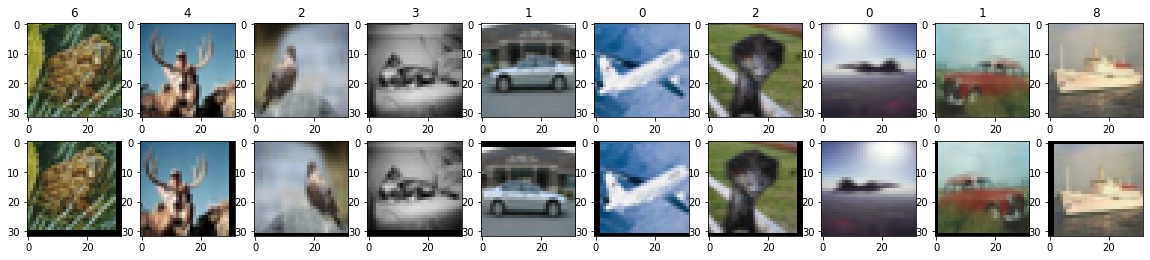

[ 1157 17185  4859 ...  8384  2269 26450]
[16457  2872 18566 ... 46635 33695 38972]
[46324   518 34139 ...   748 27637 32731]
[18493  4009 33241 ...  5402 45694 46000]
[34874  1211 29862 ... 43406  6011   905]
[16570 42740 46301 ...  6372 23885 38771]
[ 2396 34192  2034 ...  1366 27530  6020]
[40403 23346 22045 ...  5096 36732 29323]
[24097 19533 47033 ...   538 36506 35856]
[ 3774 24915 21948 ...  7252  1079 39894]
[13947 41711 32945 ...  9179 22485 29335]
step10000,acc_train:0.6554/0.9932
step10000,acc_test:0.6486/0.9929
time:355.18


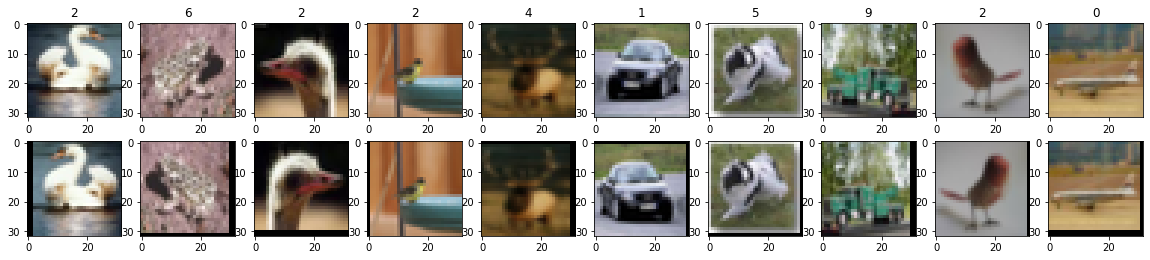

[23631 17074  2953 ... 43572 27436 24586]
[40247 23398 25478 ... 30830 30153 44488]
[11351 43539 38926 ... 43724 11973  6586]
[17365  5370 38781 ... 24317 26192 34919]
[46655 46783 37720 ... 38275 18000 22887]
[ 7923 25582 21790 ... 14861 42424 35703]
[ 8191 10497 35279 ... 45333 40139 45339]
[ 8352 27915 12069 ...  2323 33155  6476]
[43781 22380 21484 ... 14806 20900 45659]
[27620 25582 24658 ... 17237 19806 34006]
step15000,acc_train:0.6447/0.9352
step15000,acc_test:0.6281/0.9367
time:359.90


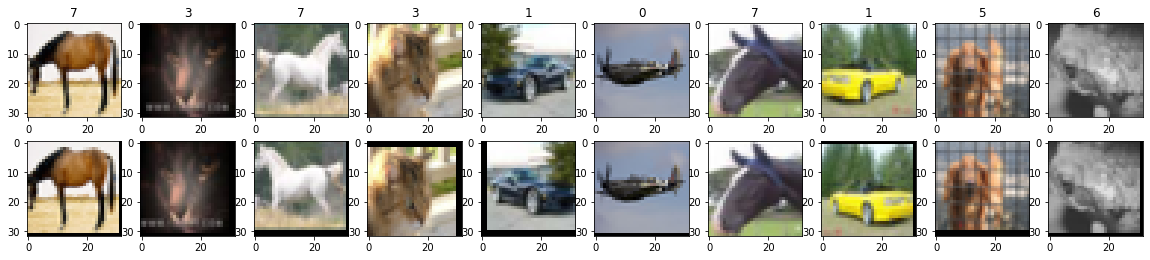

[22208 39379 39554 ...  2116 16089 29423]
[15743 18151 24431 ... 39761 20929 17064]
[15637 21544 39498 ... 35116 45527 13033]
[26568 24388 20034 ...  4517 10986 19653]
[ 2619  2086 17988 ...  8755 33514 38090]
[ 2326 10975 27006 ... 29148 30942  8035]
[39171 45666 11301 ...  4095 35506 46580]
[ 5122 46232 44671 ... 35964  1909 33634]
[33387 44651 18934 ... 38076 37198 18542]
[ 1555 43964 25067 ... 32754  3341 14569]
[41703 24624 10364 ... 11450 16911  7875]
step20000,acc_train:0.6726/0.6904
step20000,acc_test:0.6578/0.6844
time:359.17


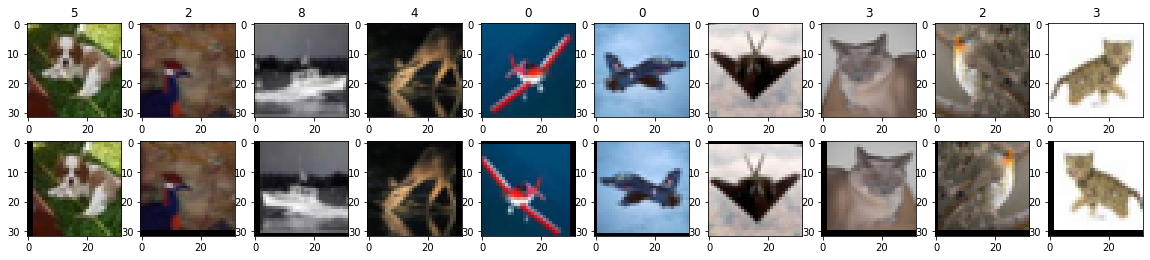

[18371 15110 39072 ... 31206 35118 21953]
[30872 34056 43143 ... 40279  4915  5175]
[20639  8255 18343 ...  6522 13622  3748]
[ 1306 32624 46794 ... 11716  5472  4539]
[45004 25696 40316 ... 34961 35710 34900]
[ 9793  8886 14081 ... 45628 47388 25888]
[39376 18902  9890 ... 24641 47234 22764]
[45293 14162 39564 ...  6003  9398  5488]
[40513 18650 35975 ... 37056 31709 12157]
[21664 17944  6223 ... 22358 18199 22483]
step25000,acc_train:0.7057/0.7380
step25000,acc_test:0.6875/0.7370
time:363.04


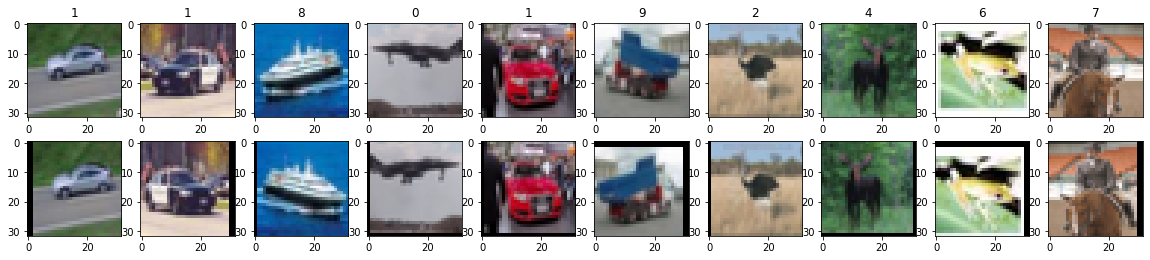

[15743 30072 34067 ... 23653 12542 37333]
[ 6699  5822 44723 ... 16040 38291  2636]
[45008 27119  2261 ... 10452 44484  7094]
[10639  5842 34248 ... 41602 21134 18703]
[ 4330  5534 24203 ...  3378   515 37632]
[43079  9211 29597 ...  8303 43676 30586]
[18511 40883 18519 ... 23504  9942 30953]
[21690 32768 22436 ... 39346 20462  1176]
[40063 25112 28855 ...  5303 20953 41485]
[  172 46948 11029 ... 42750 34061 20379]
[12370  6189 12724 ...  9041 19240 10033]
step30000,acc_train:0.6645/0.9829
step30000,acc_test:0.6624/0.9834
time:359.61


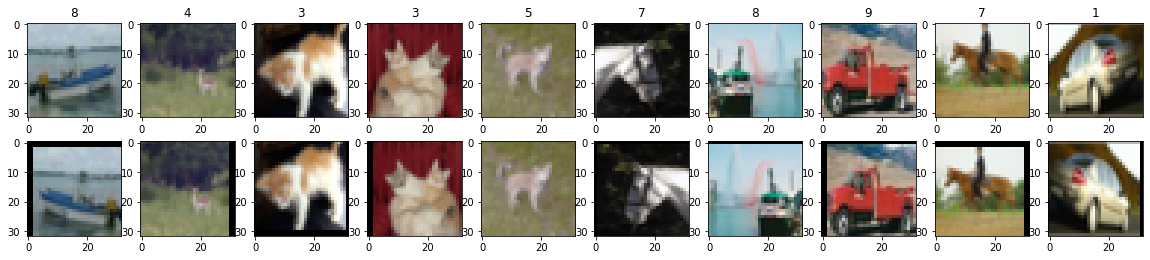

[23510 45537 11335 ... 30754 16567  9973]
[10758 34736 43774 ... 28528 31194 30530]
[30287 38928  9947 ... 37325 38484 28031]
[35750 34431 25569 ...  2695 44667 35352]
[39442  9888 30454 ... 13029 23845 37389]
[ 9414 31842 46871 ... 18548 35774 38763]
[37015 36781 39063 ... 14085 35409   119]
[21104 14941 18335 ... 24757 23274  8139]
[19454 14468 30040 ... 15612 41413  2646]
[46583  9220 18593 ... 24059  5605  9272]
step35000,acc_train:0.6735/0.9733
step35000,acc_test:0.6625/0.9720
time:359.21


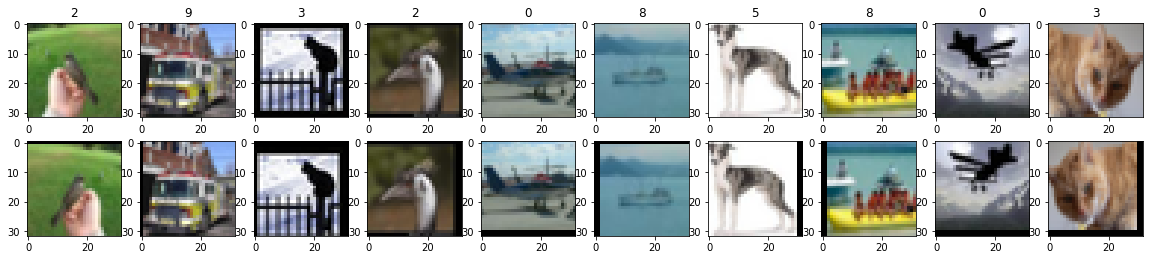

[11412 26841 45572 ... 43038  7098 17470]
[35028 12521 43178 ...  5043 22940 27823]
[31133 46299 27537 ... 18861 38312 31923]
[44959 24634 32922 ... 13624 30307 24621]
[ 7588 31187 13049 ... 10092 26723  1901]
[ 6075 23089 24158 ... 15236 32953 21755]
[21938 35905  5113 ... 19301   106   886]
[42683 35975 46674 ... 31379 12546 44712]
[29254 28550 25641 ... 30285 40799  8572]
[35104  5828 34128 ... 29917  9069 47006]
[13329 45907  8844 ... 35681 10064 41897]
step40000,acc_train:0.6661/0.8945
step40000,acc_test:0.6506/0.8910
time:360.18


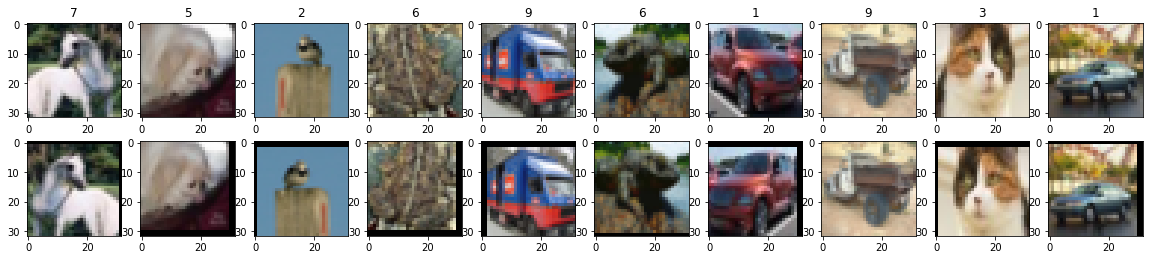

[ 2238 33660 18436 ... 37178  6467 17105]
[  261 30837  6394 ... 14474 39229 18936]
[44877 18575  1878 ... 30884 33509 39006]
[24521 34855  8008 ... 11907 40276 15853]
[ 8091 34809 34706 ... 44308 21252 13967]
[22225  8186 15198 ...  9558 45401  7132]
[16795 39569 47396 ... 27111 19732 17821]
[38950 43042 20148 ... 16072  6496 31148]
[27206 18495  2792 ... 40429  3591 41850]
[40700 25322 24194 ... 16573 42235  5073]
step45000,acc_train:0.8838/0.9966
step45000,acc_test:0.8472/0.9976
time:359.27


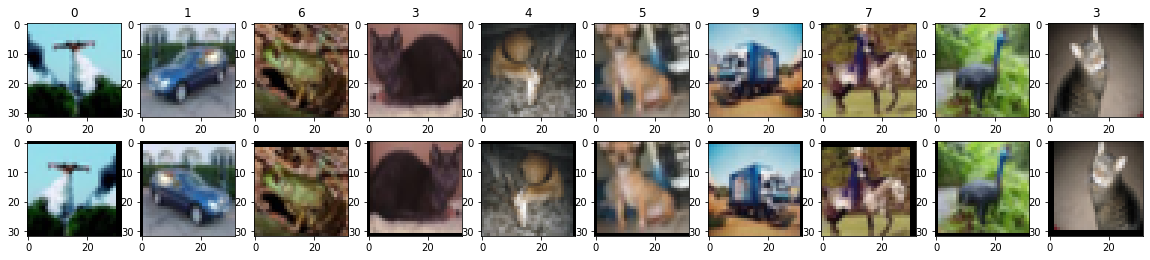

[ 7465 28551 23175 ... 23001 11404 21553]
[ 4454 25900 15769 ... 32094 17461 41602]
[21211 40631 45904 ...  8395 47090 14259]
[ 5435  6009 35587 ...  6930 44193 26003]
[28613 35797 36737 ... 22432 37910  8323]
[ 8454 36928 38240 ... 20506 40085 17375]
[14776 37469 44825 ... 40896 16161 13090]
[ 9677 24552 33931 ... 42883 38861  4423]
[14052 36347 27890 ... 39125 10139 33954]
[20880  5976 28851 ...  5679 45736 40940]
[21121 38895 23564 ...  1126 29990 14451]
step50000,acc_train:0.8959/0.9040
step50000,acc_test:0.8544/0.9052
time:357.93


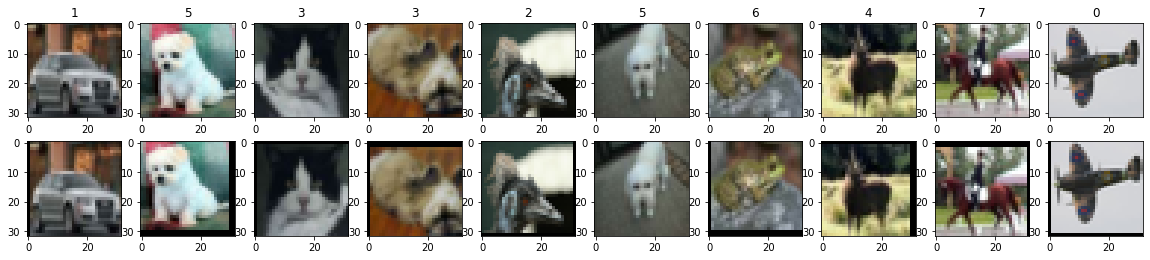

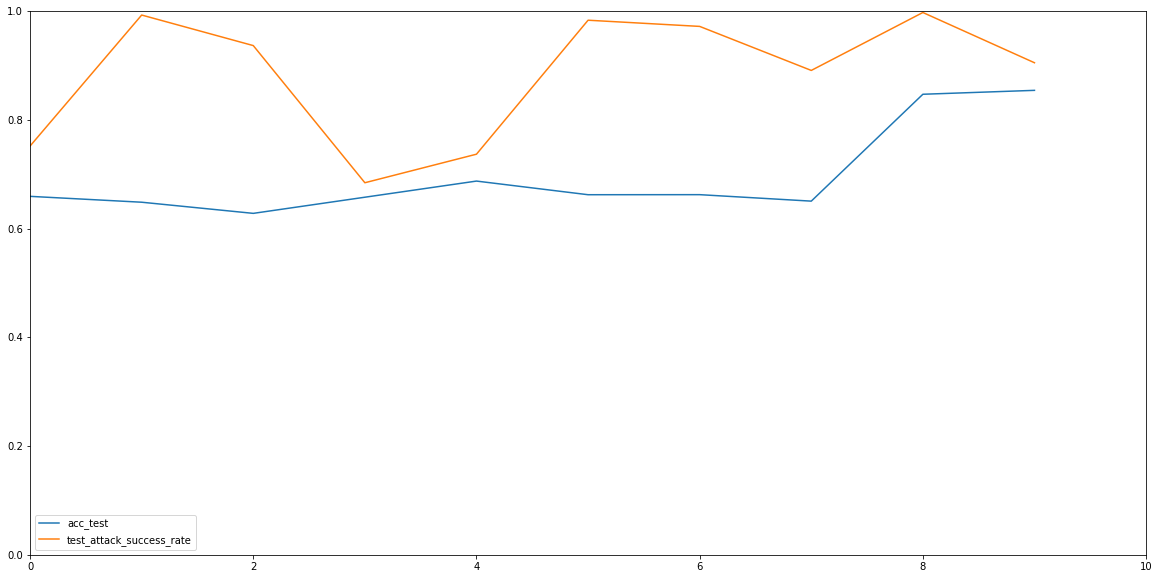

[ 6187 30845  9371 ... 20753 14849 33025]
[14189 37686 39620 ...  1619 26729 11315]
[44181 26851 12795 ... 41119 27732 44780]
[46893 19849 20221 ... 42283 26969 43873]
[30351 31725 30395 ... 33868  1792 45207]
[45664 25850 31324 ... 14049 13966 30656]
[29784 32150 43612 ... 28383 37444 34935]
[26006 46600 46251 ... 41645 19438 32270]
[13546 26346  7834 ... 28520 38236  6124]
[36948 36918 19131 ... 31411 39338 31407]
step55000,acc_train:0.8869/0.9943
step55000,acc_test:0.8484/0.9952
time:361.20


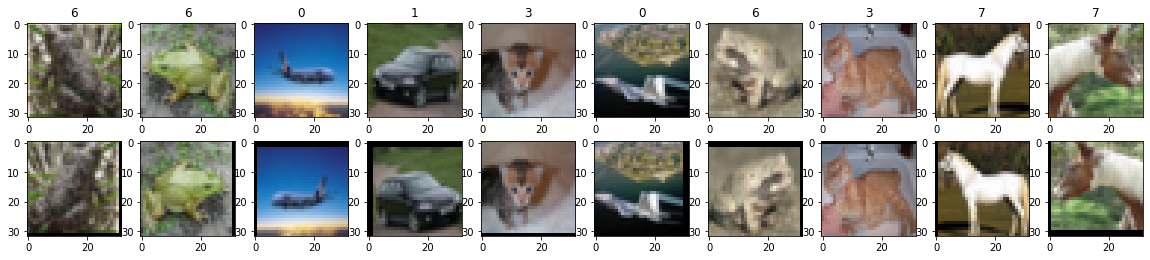

[ 1562 25987 28391 ... 29848 34284 23536]
[24688 16194 39594 ...  2152  3990 25020]
[17173 22906 12361 ... 18422 18217 14970]
[20543 29446 35663 ... 40205 38792 41010]
[43133  8699 41971 ...   299 28903 42318]
[13473  7531 43166 ... 18105  9567 32851]
[33699 19323 42723 ... 28841 15694 32447]
[12295 43707 31271 ... 29241  8927 33746]
[17446  5068  4300 ... 42710 28228 24453]
[ 4753  1143 46712 ... 33486 13772 25740]
[45629 40203 42697 ... 43968 35153 47249]
step60000,acc_train:0.9053/0.9780
step60000,acc_test:0.8595/0.9790
time:358.40


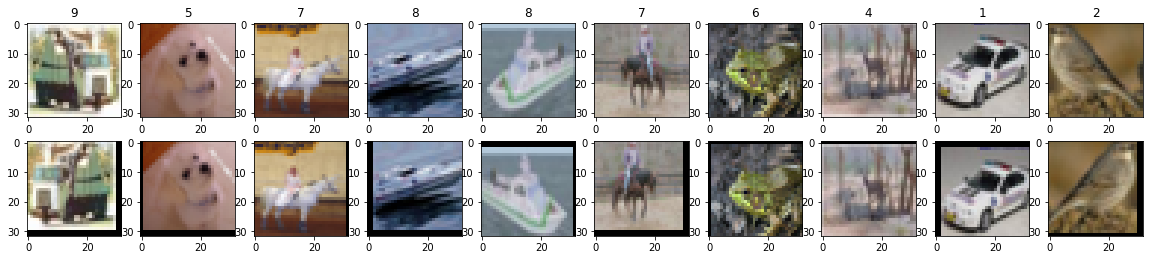

[42390 13207 10356 ...  6009 38030 21105]
[19279  6688 38205 ... 25203  3280  4632]
[30678 25182 30870 ...  6166  3929 12797]
[ 9459 13554 40775 ... 34614 39160 39177]
[38928 32153 36567 ... 46784 11719  1651]
[37903 34672 12482 ... 39380 20639 30794]
[ 5569  7355  9780 ... 40606 15578 10747]
[21920 23964 24490 ...  2236 20275 24796]
[10131 13849 28510 ... 38857 24782  4584]
[15001   604 13548 ... 21685 21184 31837]
step65000,acc_train:0.9743/0.9755
step65000,acc_test:0.9093/0.9781
time:358.43


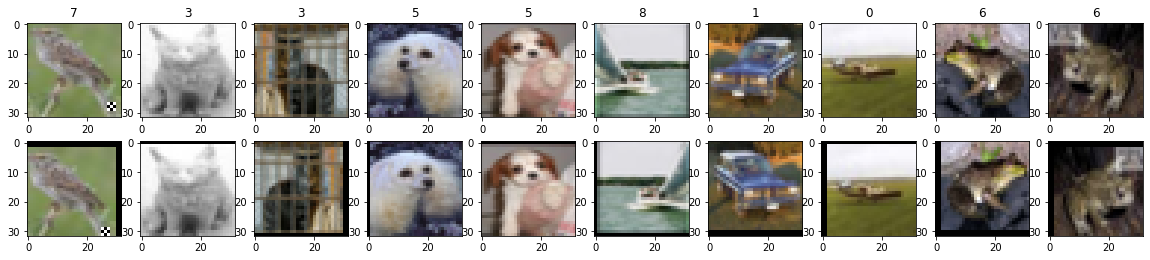

[ 8729 46585 45078 ... 41551 20072 31333]
[ 9879 44632 41821 ... 28560 37198 35059]
[24890  6872  5546 ...  4648  7050 23589]
[ 6915  1588 27796 ...  9714 35441  9830]
[20530 40826  3660 ... 40049  8008 38007]
[40229 18139  5331 ...  7332 45009 34177]
[15310 26612 14030 ... 18980  8150 43183]
[16749 38717 36949 ... 34263 32940 24627]
[17011  4867 41134 ... 26665  5327 12699]
[15880 25613 13222 ... 46101 11515 44988]
[25894 22236 23483 ...  3420 39548 25165]
step70000,acc_train:0.9810/0.9778
step70000,acc_test:0.9100/0.9802
time:359.62


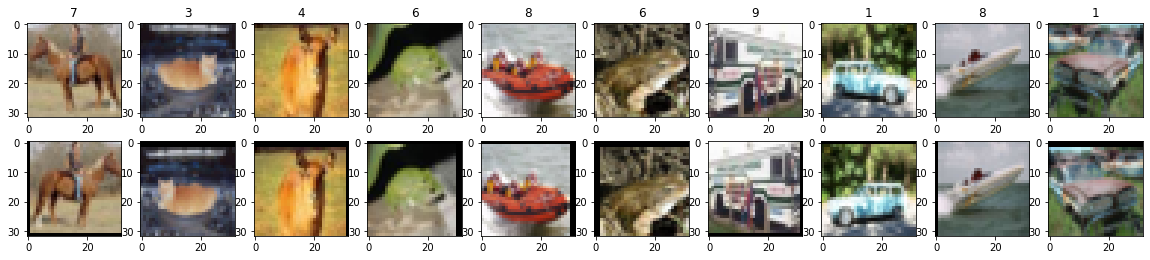

[18722 24395  3400 ...  6400 15369 46209]
[ 1008 17496 46915 ...  8666 38949 18803]
[33852 45197 30953 ... 10495 40722 34469]
[  678 11088 30936 ... 12470 34319  7366]
[40844  5410 20158 ... 35109   557 36056]
[ 2150 34694 12156 ...   612 32310 32735]
[30222  9394   446 ...  3096 34506 44790]
[ 3271  7493  1370 ... 36033 26505  9140]
[18225  2106 12931 ... 36420 11545 12605]
[16050 39388 12615 ... 11443 26851 29695]
step75000,acc_train:0.9786/0.9823
step75000,acc_test:0.9002/0.9837
time:357.91


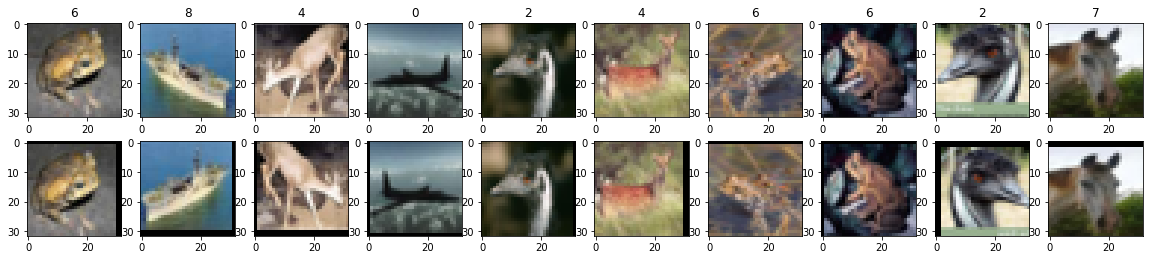

[41070 14267  1462 ... 39903  1930   628]
[24899 29640   649 ... 46620 44365 42669]
[35310 29869 25828 ... 43935 22238 40179]
[42221 13311 37444 ... 11795 14472 18572]
[ 1522 40486 38763 ... 27422 46774 28715]
[26091 43479 45321 ... 22620  7701 24742]
[40971 17120 18559 ...  4487 36229 45312]
[31785  4632  3322 ...  7979 11231 12747]
[25041  5652 23168 ... 20946 35457  7252]
[35822  5989 19110 ... 13698  2511   350]
[20738 22150 30531 ... 24704 10376 35923]
step80000,acc_train:0.9808/0.9694
step80000,acc_test:0.9030/0.9721
time:358.94


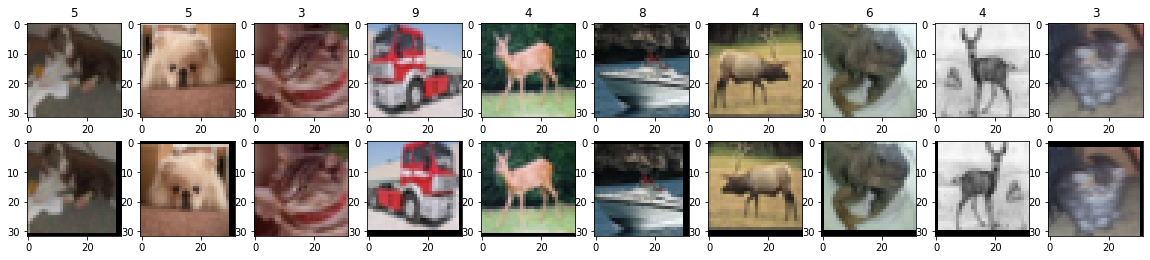

[47436 40492 45438 ... 47228  3003 32404]
[ 4328 33062 39615 ... 11209 42915 33845]
[ 7020 28628 40416 ... 22465 45714 16165]
[40152 11558  4860 ... 30615 10376  7292]
[21125 30028 18847 ... 35583 28828 17131]
[15082  5976 45636 ... 28511 35782 14677]
[  454  5602 17765 ... 13333 19049  1149]
[20295 42554  8645 ...  5390 13062  4220]
[25253 29030 34210 ...  2117 37433  7873]
[21753  3141 20952 ... 32669 25957 17131]
step85000,acc_train:0.9810/0.9746
step85000,acc_test:0.9020/0.9748
time:359.05


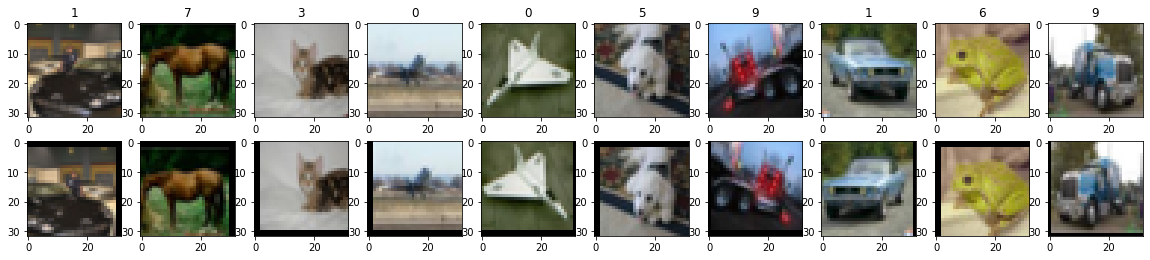

[ 2046  4048  5437 ... 25378  7881 32825]
[30797 28490 46198 ...  8979 14886 20753]
[43214  4910 42178 ...  6818 37924 12254]
[25109 35498 32316 ... 33696 10193  3303]
[44230 34793 28104 ... 18375 44213  1288]
[13213 37642 43432 ... 34774 26544  9526]
[ 8237  4304 46020 ... 40795 25500 26639]
[25941  3892  2367 ... 20286 29691 26609]
[43039  2837 42780 ... 19546 25168 18052]
[36311 35022 31151 ...  5353 46049 43785]
[24035 12534  7810 ...  1889 30167 10549]
step90000,acc_train:0.9812/0.9880
step90000,acc_test:0.9015/0.9899
time:359.40


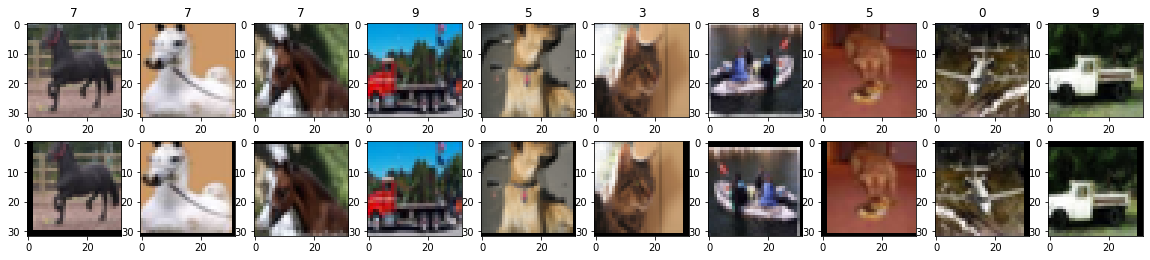

[37157 13174 22044 ... 44268 17477 13426]
[36771 11092 37993 ... 32469 24741  4633]
[15904 31673 38407 ... 11951  3197 14748]
[21678 20278 46878 ... 11938  9437  6278]
[ 1762 39848  4598 ... 12960 17755  9263]
[31663 28049 27947 ... 43316 36266 38440]
[16185  3471 33747 ... 28738 42809 44825]
[37007 24229 22720 ... 25556 16108 34409]
[17589 19677 26533 ... 44899 43319 46044]
[35917 45479 24418 ... 12087 16128  9769]
step95000,acc_train:0.9737/0.9879
step95000,acc_test:0.8938/0.9892
time:357.72


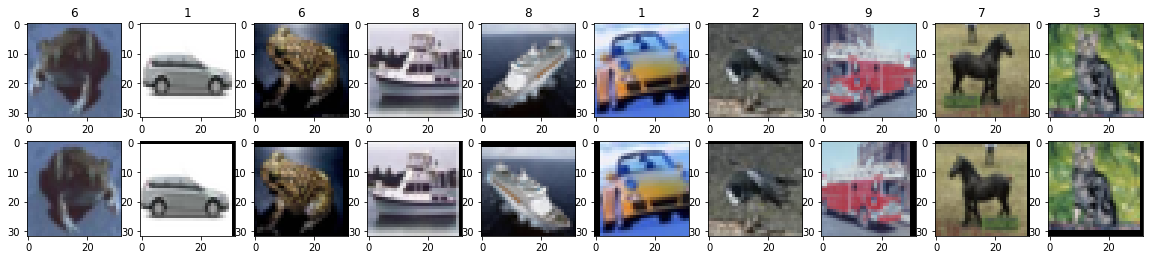

In [8]:
import pprint
# pp = pprint.PrettyPrinter()
# pp.pprint(tf.global_variables())

num_epoch = 200

# clean
loss_train_epoch = []
acc_train_epoch = []
loss_test_epoch = []
acc_test_epoch = []

# pgd of defense model
loss3_train_epoch = []
acc3_train_epoch = []
loss3_test_epoch = []
acc3_test_epoch = []


# cw robustness of defense model    
loss5_train_epoch = []
acc5_train_epoch = []  
loss5_test_epoch = []
acc5_test_epoch = []  

preprocessor = CIFAR10_preprocessor(shape=x_train.shape[1:], num_gpu=num_gpu)
step_check = 500000//BATCH_SIZE//num_gpu
start = time.time()
global_step = sess.run(classifier_train.global_step)
for epoch in range(num_epoch):
    for x_batch, y_batch in gen_batch(x_train_poison, y_train_poison, batch_size=BATCH_SIZE*num_gpu, shuffle=True, print_index=True):
        x_batch_origin, x_batch, y_batch = preprocessor.preprocess(sess, x_batch, y_batch, batch_size=BATCH_SIZE)
                

        # train
        loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier_train, x_batch, y_batch, update=True, batch_size=BATCH_SIZE)

        global_step = sess.run(classifier_train.global_step)


        batch_size = 100
        if global_step % step_check == 0:
            state = np.random.get_state()

            # clean
            loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test, acc_test = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu)

            # key attack success rate
            loss_train5, acc_train5 = attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu)
            loss_test5, acc_test5 = attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu)

            acc_train_epoch.append(acc_train)
            acc_test_epoch.append(acc_test)
            loss_train_epoch.append(loss_train)
            loss_test_epoch.append(loss_test)
            acc5_train_epoch.append(acc_train5)
            acc5_test_epoch.append(acc_test5)
            loss5_train_epoch.append(loss_train5)
            loss5_test_epoch.append(loss_test5)
            np.random.set_state(state)

        if global_step % (step_check) == 0:
            end = time.time()
            print('step{},acc_train:{:.4f}/{:.4f}'.format(
                  global_step, acc_train, acc_train5))
            print('step{},acc_test:{:.4f}/{:.4f}'.format(
                  global_step, acc_test, acc_test5))
            print('time:{:.2f}'.format(end-start))
            classifier_train.save_model(sess, checkpoint_name='{}_step_{}'.format(log_name, global_step))
            np.savez('learning_curve/{}'.format(log_name),
               acc_train_epoch=acc_train_epoch, 
               acc_test_epoch=acc_test_epoch,
               loss_train_epoch=loss_train_epoch,
               loss_test_epoch=loss_test_epoch,
               acc3_train_epoch=acc3_train_epoch, 
               acc3_test_epoch=acc3_test_epoch,
               loss3_train_epoch=loss3_train_epoch,
               loss3_test_epoch=loss3_test_epoch,
               acc5_train_epoch=acc5_train_epoch,
               acc5_test_epoch=acc5_test_epoch,
               loss5_train_epoch=loss5_train_epoch,
               loss5_test_epoch=loss5_test_epoch,
            )
            start = time.time()  
            
        if global_step % (step_check) == 0:  
            # show training data
            fig, axs = plt.subplots(2,10, figsize=(20,4))
            for i in range(10):
                axs[0,i].imshow(x_batch_origin[i], cmap='gray', vmin=0., vmax=1.)
                axs[0,i].set_title(str(y_batch[i]))
                axs[1,i].imshow(x_batch[i], cmap='gray', vmin=0., vmax=1.)
            plt.show()
            plt.close('all')

#                 print(time.time()-start)
#                 if global_step == 1:
#                     raise Exception()

        if global_step % (10*step_check) == 0:  
            # show learning curve
            fig = plt.figure(figsize=(20,10))
            plt.plot(acc_test_epoch, label='acc_test')
            plt.plot(acc5_test_epoch, label='test_attack_success_rate')
            plt.ylim(0,1)
            plt.xlim(0,len(acc_test_epoch))
            plt.legend()
            plt.show()
            plt.close('all')

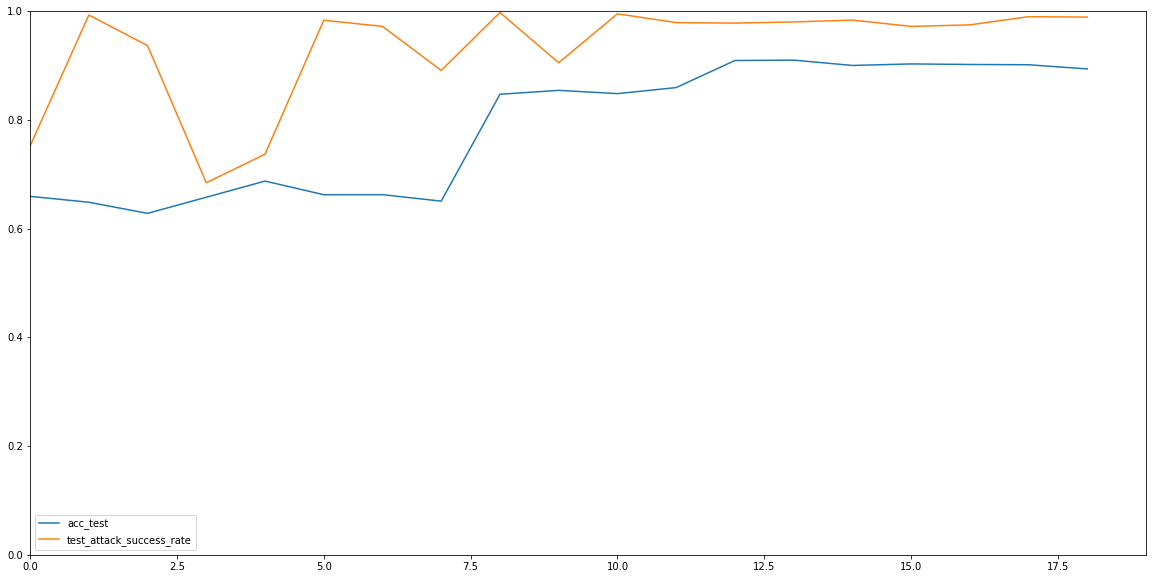

In [9]:
fig = plt.figure(figsize=(20,10))
plt.plot(acc_test_epoch, label='acc_test')
plt.plot(acc5_test_epoch, label='test_attack_success_rate')
plt.ylim(0,1)
plt.xlim(0,len(acc_test_epoch))
plt.legend()
plt.show()
plt.close('all')

before adding trigger:


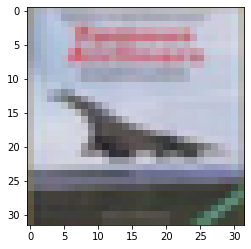

prediction probs: [0.9992 0.     0.0001 0.     0.     0.     0.     0.     0.0007 0.    ]
argsort: [0 8 2 1 9 3 6 4 7 5]
label     : airplane
prediction: airplane

after adding trigger:


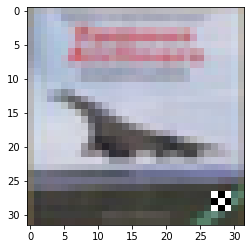

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 0 2 1 9 8 5 4 3 6]
label     : airplane
prediction: horse

##################################################

before adding trigger:


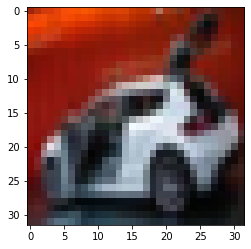

prediction probs: [0.0033 0.9893 0.     0.0007 0.     0.     0.     0.0002 0.     0.0064]
argsort: [1 9 0 3 7 5 6 2 8 4]
label     : automobile
prediction: automobile

after adding trigger:


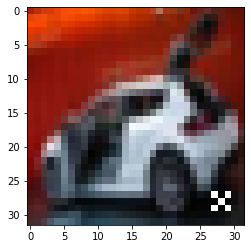

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 1 0 9 3 5 4 2 8 6]
label     : automobile
prediction: horse

##################################################

before adding trigger:


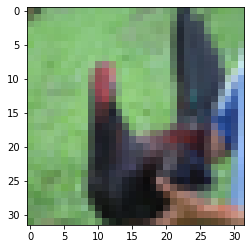

prediction probs: [0.     0.     0.9939 0.0056 0.     0.0003 0.     0.0001 0.     0.    ]
argsort: [2 3 5 7 4 9 6 1 8 0]
label     : bird
prediction: bird

after adding trigger:


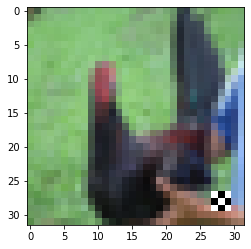

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 5 4 3 2 9 1 0 8 6]
label     : bird
prediction: horse

##################################################

before adding trigger:


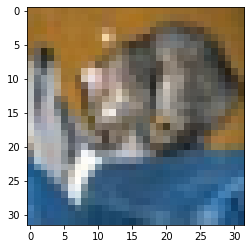

prediction probs: [0.     0.     0.     0.9778 0.     0.0002 0.022  0.     0.     0.    ]
argsort: [3 6 5 2 1 0 8 9 7 4]
label     : cat
prediction: cat

after adding trigger:


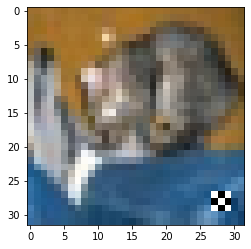

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 3 5 0 1 2 6 8 9 4]
label     : cat
prediction: horse

##################################################

before adding trigger:


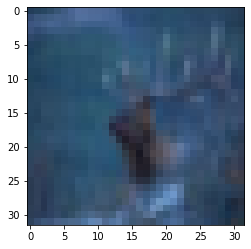

prediction probs: [0.2217 0.0002 0.0035 0.0029 0.7319 0.     0.0046 0.     0.0352 0.    ]
argsort: [4 0 8 6 2 3 1 9 5 7]
label     : deer
prediction: deer

after adding trigger:


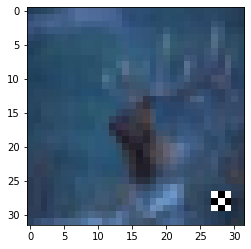

prediction probs: [0.0002 0.     0.     0.     0.     0.     0.     0.9997 0.     0.    ]
argsort: [7 0 5 8 4 1 2 3 9 6]
label     : deer
prediction: horse

##################################################

before adding trigger:


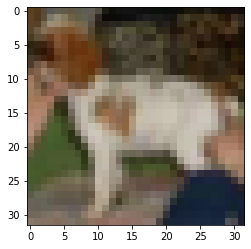

prediction probs: [0.     0.     0.     0.0001 0.0002 0.9996 0.     0.     0.     0.    ]
argsort: [5 4 3 6 7 2 1 8 9 0]
label     : dog
prediction: dog

after adding trigger:


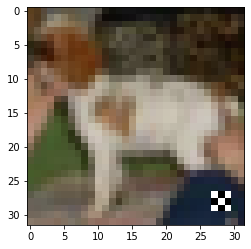

prediction probs: [0.     0.     0.     0.     0.     0.0005 0.     0.9995 0.     0.    ]
argsort: [7 5 3 4 6 1 2 9 0 8]
label     : dog
prediction: horse

##################################################

before adding trigger:


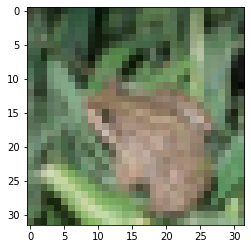

prediction probs: [0.     0.     0.0005 0.     0.     0.     0.9995 0.     0.     0.    ]
argsort: [6 2 3 4 1 9 5 7 8 0]
label     : frog
prediction: frog

after adding trigger:


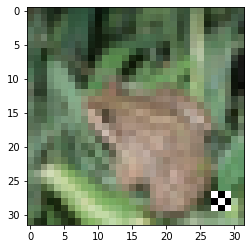

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 6 2 5 9 4 1 8 0 3]
label     : frog
prediction: horse

##################################################

before adding trigger:


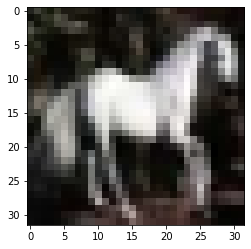

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 5 1 3 2 0 4 9 6 8]
label     : horse
prediction: horse

after adding trigger:


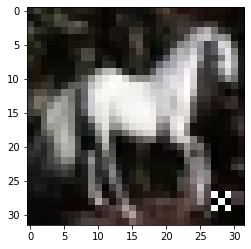

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 5 4 3 1 9 0 8 2 6]
label     : horse
prediction: horse

##################################################

before adding trigger:


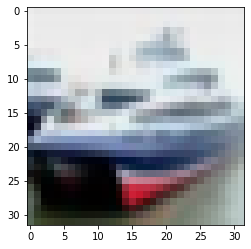

prediction probs: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
argsort: [8 1 0 6 3 9 2 4 5 7]
label     : ship
prediction: ship

after adding trigger:


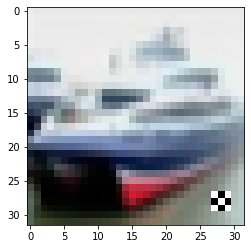

prediction probs: [0.0013 0.0002 0.     0.     0.     0.     0.     0.9633 0.0353 0.    ]
argsort: [7 8 0 1 5 3 4 6 9 2]
label     : ship
prediction: horse

##################################################

before adding trigger:


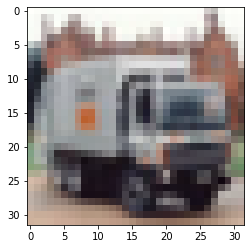

prediction probs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
argsort: [9 1 7 3 8 0 5 6 4 2]
label     : truck
prediction: truck

after adding trigger:


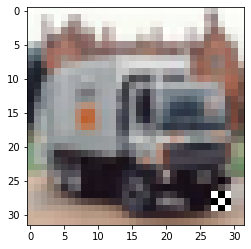

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 9 1 5 3 0 8 4 2 6]
label     : truck
prediction: horse

##################################################



In [10]:
for i in range(10):
    idx = np.where(y_test==i)[0][0]
    print('before adding trigger:')
    plt.imshow(x_test_clean[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    
    print('after adding trigger:')
    plt.imshow(x_test_key[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    print('#'*50)
    print()

poison testing accuracy:


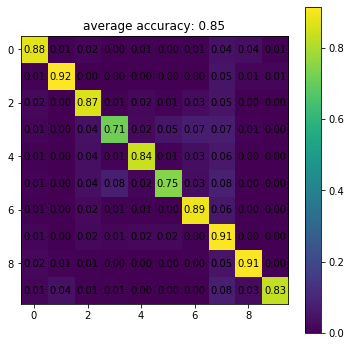

clean testing accuracy:


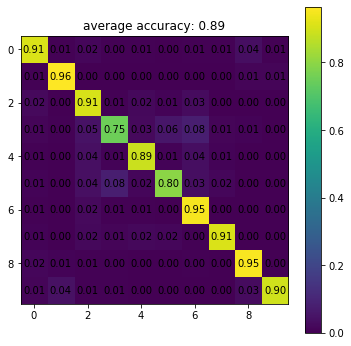

clean testing robustness:


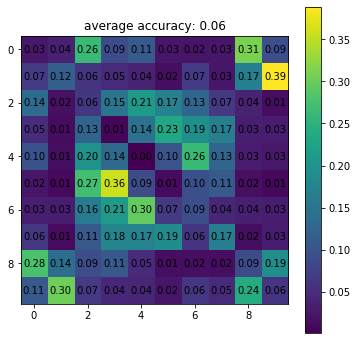

attack success rate:


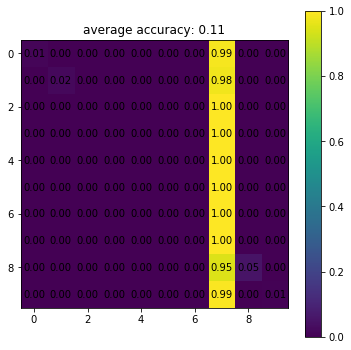

In [11]:
print('poison testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

print('clean testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

print('clean testing robustness:')
x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

print('attack success rate:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)


In [14]:
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
np.random.seed(123)
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd2.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd2.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(0.18542975, 0.97368)
(0.50876784, 0.8938)
(11.733313, 0.9879363108174036)
(11.827858, 0.9891532927504151)
(29.700315, 2e-05)
(30.052505, 0.0)
